<a href="https://colab.research.google.com/github/SJongH/GroupA/blob/main/Week1_Quiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
def timer(func):
  def wrapper(*args, **kwargs):
    start_time  = time.time()
    result = func (*args, **kwargs)
    end_time = time.time()
    computation_time = end_time - start_time
    print(f"Execution time of {func.__name__} {computation_time} seconds")
    return result
  return wrapper

In [2]:
# Data Generation

import numpy as np

true_b = 1
true_w = 2
N = 100

np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (0.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon
# * : dot product, @ : matrix multiplication

In [3]:
# Train-Validation Split

idx = np.arange(N)
split_idx = int(0.8 * N) # 4:1로 나누는게 국룰
train_idx = idx[:split_idx]
val_idx = idx[split_idx:]

x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

# scikit-learn 패키지로 쉽게 가능

In [4]:
@timer
def train_model_numpy(lr = 0.1, epochs = 1000):
  b = np.random.randn(1)
  w = np.random.randn(1)

  for epoch in range(epochs):
    y_hat = b+w*x_train
    error = (y_hat - y_train)
    mse_loss = np.mean(error ** 2)


    b_grad = 2 * np.mean(error)
    w_grad = 2 * np.mean(x_train * error)
    b = b - lr * b_grad
    w = w - lr * w_grad
  return b, w


In [5]:
b, w = train_model_numpy()

print('b_estimate: {}, w_estimate: {}'.format(b, w))

Execution time of train_model_numpy 0.025795698165893555 seconds
b_estimate: [1.02341376], w_estimate: [1.93680725]


In [6]:
# Data Generation with Pytorch

import torch
# create tensor in cpu
x_train_tensor = torch.as_tensor(x_train)
y_train_tensor = torch.as_tensor(y_train)

# create tensor in gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x_train_tensor = torch.as_tensor(x_train).to(device)
y_train_tensor = torch.as_tensor(y_train).to(device)

In [7]:
@timer
def train_model_torch(lr = 0.1, epochs = 1000):
  b = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)
  w = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)

  for epoch in range(epochs):
    y_hat = b + w * x_train_tensor
    error = (y_hat - y_train_tensor)
    mse_loss = torch.mean(error**2)
    mse_loss.backward()

    # in-place operation 을 이용하므로 no_grad로 사용해야함
    # 일정한 id를 유지하기위해 in-place operation을 사용함

    with torch.no_grad():
      b -= lr * b.grad
      w -= lr * w.grad
    # _: in-place operation 사용하라는 규칙
    b.grad.zero_()
    w.grad.zero_()
  return b, w

In [8]:
b, w = train_model_torch()
print('b_estimate: {}, w_estimate: {}'.format(b.item(), w.item()))

Execution time of train_model_torch 1.1864962577819824 seconds
b_estimate: 1.0234160423278809, w_estimate: 1.936802864074707


In [9]:
import torch.optim as optim
import torch.nn as nn

def train_model_torch(lr = 0.1, epochs = 1000):
  b = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)
  w = torch.randn(1, requires_grad = True, dtype = torch.float, device = device)
  parameters = [b, w]
  optimizer = optim.SGD(parameters, lr = lr)
  mse_loss = nn.MSELoss()

  for epoch in range(epochs):
    y_hat = b + w*x_train_tensor
    loss = mse_loss(y_hat, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return b, w




In [10]:
b, w = train_model_torch()
print('b_estimate: {}, w_estimate: {}'.format(b.item(), w.item()))

b_estimate: 1.0234160423278809, w_estimate: 1.936802864074707


# Quiz 1
- test data 에서 MSE eroor 계산 코드 구현


In [11]:
x_val_tensor = torch.as_tensor(x_val).to(device)
y_val_tensor = torch.as_tensor(y_val).to(device)

In [12]:
y_estimate = b+ w*x_val_tensor
mseloss = nn.MSELoss()
error = mseloss(y_val_tensor, y_estimate)
print(error)

tensor(0.0098, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)


# Quiz 2
- 주어진 데이터에 fitting 하는 모델 생성하기

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
import time
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        computation_time = end_time - start_time
        print(f"Execution time of {func.__name__}: {computation_time} seconds")
        return result
    return wrapper

In [21]:
data = pd.read_pickle('quiz_data.pkl')

In [22]:
x = data['x']
y = data['y']

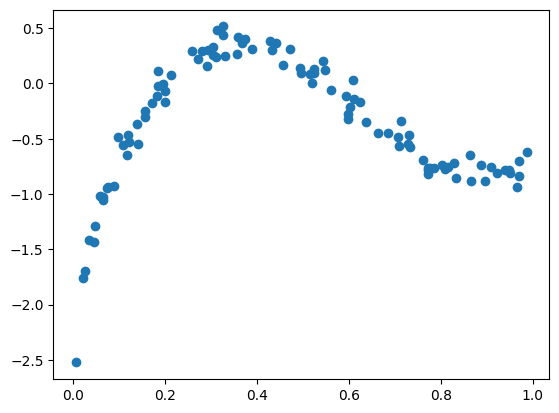

In [23]:
plt.scatter(x, y)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [25]:
N = len(x)
idx = np.arange(N)
split_idx = int(0.8 * N)
train_idx = idx[:split_idx]
val_idx = idx[split_idx:]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_x = torch.as_tensor(x[train_idx]).to(device)
train_y = torch.as_tensor(y[train_idx]).to(device)
val_x = torch.as_tensor(x[val_idx]).to(device)
val_y = torch.as_tensor(y[val_idx]).to(device)

In [26]:
@timer
def train_model(lr = 0.2, epochs = 800):
    w1 = torch.randn(1, requires_grad=True, dtype=torch.float, device = device)
    w2 = torch.randn(1, requires_grad=True, dtype=torch.float, device = device)
    w3 = torch.randn(1, requires_grad=True, dtype=torch.float, device = device)
    b = torch.randn(1, requires_grad=True, dtype=torch.float, device = device)
    parameters = [w1, w2, w3, b]
    optimizer = optim.Adam(parameters, lr=lr)
    mseloss = nn.MSELoss()
    for epoch in range(epochs):
        y_hat = w1*train_x + w2*(train_x**2)+w3*(train_x**3)+b
        loss = mseloss(y_hat, train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return [w1, w2, w3, b]

In [27]:
def compute_loss(parameter):
    y_estimate = parameter[0]*val_x + parameter[1]*(val_x**2)+parameter[2]*(val_x**3)+parameter[3]
    mseloss = nn.MSELoss()
    loss = mseloss(y_estimate, val_y)
    return loss

In [28]:
losses = []
parameters = []
for i in range(10):
    parameter = train_model()
    parameters.append(parameter)
    loss = compute_loss(parameter)
    losses.append(loss.item())

print('mean of losses: {}'.format(np.mean(losses)))

Execution time of train_model: 0.4857296943664551 seconds
Execution time of train_model: 0.47873640060424805 seconds
Execution time of train_model: 0.4671053886413574 seconds
Execution time of train_model: 0.4737071990966797 seconds
Execution time of train_model: 0.4777095317840576 seconds
Execution time of train_model: 0.4986858367919922 seconds
Execution time of train_model: 0.47770190238952637 seconds
Execution time of train_model: 0.47110605239868164 seconds
Execution time of train_model: 0.4821486473083496 seconds
Execution time of train_model: 0.4789893627166748 seconds
mean of losses: 0.032906037790179046


In [29]:
val_x_cpu = val_x.to('cpu')
val_y_cpu = val_y.to('cpu')
best_parameter = parameters[np.argmin(losses)]
estimated_y = best_parameter[0]*val_x + best_parameter[1]*(val_x**2)+best_parameter[2]*(val_x**3)+best_parameter[3]
estimated_y_cpu = estimated_y.to('cpu')

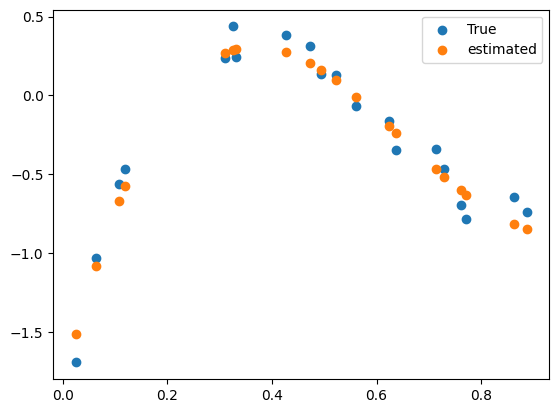

In [31]:
plt.scatter(val_x_cpu,  val_y_cpu, label = 'True')
plt.scatter(val_x_cpu, estimated_y_cpu.detach().numpy(), label = 'estimated')
plt.legend()